# Exploration of Our Tweets
Given that our problem domain is predicting a binary flag on arbitrary strings of words, our exploration space is limited to identifying overarching pattern differences in the strings of the two groups without having some compariable data structure between every sample. This does leave us with a few options though.

In [1]:
# First things first lets group our tweet texts
import pandas as pd

tweet_df = pd.read_csv('../data/processed_kaggle_training.csv')

And since we removed stop words from our tweets and tweets can be somewhat trite (or rife with typos which we also removed) we should see if we have nulls we need to fill before we get to exploring.

In [2]:
tweet_df[tweet_df.processed_text.isna()]

,Unnamed: 0,id,keyword,location,text,target,processed_text,primary_topic
19,19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0,NaN,0
421,421,611,arsonist,[ Blonde Bi Fry. ],'wHeRE's mY aRsOnISt aT???',0,NaN,0
428,428,621,arsonist,ss,who makes these? http://t.co/28t3NWHdKy,0,NaN,0
5115,5115,7295,nuclear%20reactor,NaN,Err:509,0,NaN,0
6766,6766,9697,tornado,NaN,@Ayshun_Tornado then don't,0,NaN,0


In [3]:
tweet_df['processed_text'] = tweet_df.processed_text.fillna('')

In [4]:
tweet_df[tweet_df.processed_text.isna()]

,Unnamed: 0,id,keyword,location,text,target,processed_text,primary_topic


In [5]:
safe_tweets = tweet_df[tweet_df.target == 0].processed_text.values
disaster_tweets = tweet_df[tweet_df.target == 1].processed_text.values

In [6]:
print(f"We have {len(safe_tweets)} tweets not referring to a disaster in our data set.")
print(f"We have {len(disaster_tweets)} tweets referring to a disaster in our data set.")

We have 4342 tweets not referring to a disaster in our data set.
We have 3271 tweets referring to a disaster in our data set.


The real vast majority of tweets don't refer to a disaster, so its odd to see our provided data set not further buffered with non disaster tweets, but our goal in this kaggle derived project is to get the best predictions we can with the data we are given, so we'll forego our own further buffering of the data set.

## Word Clouds
With our tweets split into our two groups of interest, we can do a standard visualization on common words to see if overall some words show up more commonly in disaster tweets vs non-disaster tweets.

In [7]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

def tweet_word_cloud(tweet_array):
    joined_tweets = " ".join(list(tweet_array))
    # some prior inspection identifies bad repeat words
    joined_tweets = joined_tweets.replace("new", "")
    joined_tweets = joined_tweets.replace("  ", " ")

    wc = WordCloud(max_words=50, background_color="white").generate(joined_tweets)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

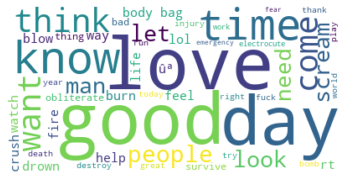

In [8]:
tweet_word_cloud(safe_tweets)

In [9]:
# the top 15 corresponding word counts follow, wordcloud has a bug
# adding an extra word to the top, so we start at index 1
good_word_counts = WordCloud().process_text(text = " ".join(list(safe_tweets)))
sorted(good_word_counts.items(), key=lambda item: item[1], reverse=True)[1:16]

[('love', 107),
 ('good', 104),
 ('day', 102),
 ('know', 102),
 ('time', 99),
 ('think', 99),
 ('want', 98),
 ('come', 93),
 ('people', 88),
 ('look', 81),
 ('let', 79),
 ('man', 77),
 ('scream', 75),
 ('need', 72),
 ('body bag', 69)]

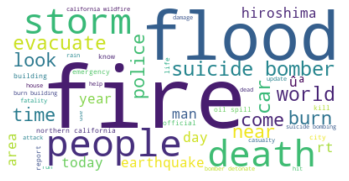

In [10]:
# and again for our disaster tweets
tweet_word_cloud(disaster_tweets)

In [11]:
good_word_counts = WordCloud().process_text(text = " ".join(list(disaster_tweets)))
sorted(good_word_counts.items(), key=lambda item: item[1], reverse=True)[1:16]

[('fire', 134),
 ('flood', 75),
 ('people', 70),
 ('storm', 64),
 ('death', 63),
 ('suicide bomber', 60),
 ('car', 59),
 ('evacuate', 55),
 ('time', 50),
 ('come', 49),
 ('look', 49),
 ('police', 48),
 ('burn', 47),
 ('near', 46),
 ('world', 45)]

## SNE
We can also feed the TF-IDF representation of our processed tweets that we made in processing to the t-SNE algorithm, which aims to transform multidimensional data into two dimensions while preserving the distance between points as much as possible. While this is a somewhat out of box application of this algorithm, it's of interest to see if the algorithm can make out some overarching difference between the vectors representing disaster tweets and those representing non disaster tweets. If the points end up displayed completely randomly it may be a hint we're on a path with limited predictive capability, while a good separation would be a good signal that our preprocessing steps have helped us on our way.

In [12]:
# load our tf-idf representations
import scipy.sparse
Xtfidf = scipy.sparse.load_npz('../data/tweets-tf-idf.npz')

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE()
tsne_vectors = tsne.fit_transform(Xtfidf.toarray())

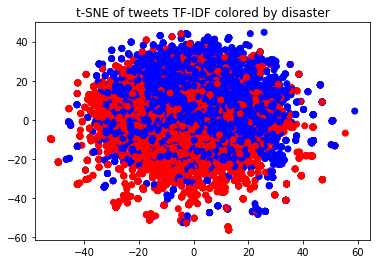

In [14]:
from matplotlib import pyplot as plt
plt.title('t-SNE of tweets TF-IDF colored by disaster')
_ = plt.scatter(tsne_vectors[:,0],tsne_vectors[:,1], color=tweet_df['target'].map({0: 'blue', 1: 'red'}))
plt.show()

And while there's a lot of randomness here, we do see distinctly more blue (representing transformed safe tweets) to the upper right, and more transformed disaster tweet points to the lower right, which does suggest some seperability capability for our NLP algorithms.

## LDA topics
We previously computed the most likely topics for each tweet. In the end this is unlikely to be that insightful either though just due to the short length of words any one tweet can contain. But we can still see if any topics are particularly dangerous.

In [11]:
# get our value counts for the bar graphs
safe_topic_counts =\
    tweet_df[tweet_df.target == 0].primary_topic.value_counts().sort_index()
    
dis_topic_counts =\
    tweet_df[tweet_df.target == 1].primary_topic.value_counts().sort_index()

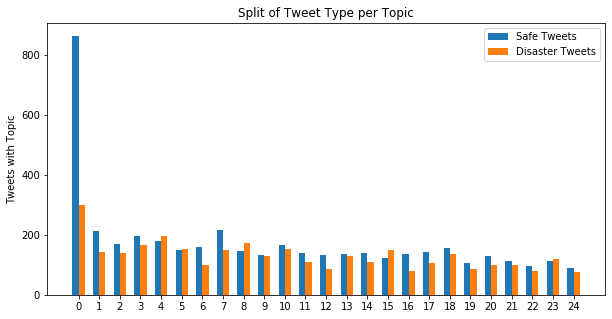

In [18]:
from matplotlib import pyplot as plt
import numpy as np

NUM_TOPICS = 25
BAR_WIDTH = 0.3

# bar positions for our plots
ind = np.arange(NUM_TOPICS)

plt.figure(figsize=(10,5))

plt.bar(ind, safe_topic_counts, BAR_WIDTH, label="Safe Tweets")
plt.bar(ind+BAR_WIDTH, dis_topic_counts, BAR_WIDTH, label="Disaster Tweets")
plt.xticks(ind + BAR_WIDTH/2, ind)

plt.ylabel("Tweets with Topic")
plt.title("Split of Tweet Type per Topic")

plt.legend(loc='best')
plt.show()

As we expected with our particular data set, most topic sets have fairly equal representation between 'safe' tweets and disaster tweets. Only the first topic has difference that deems any suggestive capability. We can load our model to see the types of words in this topic.

In [20]:
from gensim.models.ldamulticore import LdaMulticore

lda = LdaMulticore.load('../data/lda_topic_models')

In [21]:
for term, frequency in lda.show_topic(0, topn=25):
        print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))

like                 0.014
survive              0.007
suicide              0.006
wreck                0.006
day                  0.005
kill                 0.005
think                0.005
war                  0.004
traumatised          0.004
good                 0.004
police               0.004
let                  0.004
come                 0.003
bombing              0.003
bad                  0.003
car                  0.003
stop                 0.003
crash                0.003
kid                  0.003
zone                 0.003
look                 0.003
need                 0.003
70                   0.003
watch                0.003
survivor             0.003


But even in this topic just the presense of 'police,' a word for a group we wish to respond in the case of an emergency, should tell us that we shouldn't be looking to topic modeling for categorizing our tweets.

Going onto machine learning our word clouds do indicate some difference between safe and disaster tweets, and so we might expect Naive Bayes and Neural Networks to be our best tools for discovering the intent of tweets, though we'll also examine the predictive capability of other popular classifiers, such as SVC and Random Forest.